In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Base models imports
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

In [61]:
# Define base models
base_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Define meta-learner (MLP)
meta_learner = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='logistic',
    solver='adam',
    random_state=42,
    max_iter=1000,
    
)

## meta feature generation

In [62]:
def generate_hybrid_meta_features(base_models, X_train, X_test, y_train, n_top_features=5, use_smote=False):
    """Generate meta-features combined with top important original features"""
    
    # Get base model meta-features
    meta_train = np.zeros((X_train.shape[0], len(base_models)))
    meta_test = np.zeros((X_test.shape[0], len(base_models)))
    cv_scores = {}
    
    # Get feature importance from AdaBoost
    ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
    ada_model.fit(X_train, y_train)
    
    # Get top N important features
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': ada_model.feature_importances_
    })
    top_features = feature_importance.nlargest(n_top_features, 'importance')['feature'].tolist()
    
    # Generate meta-features with cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for i, (name, model) in enumerate(base_models.items()):
        fold_scores = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            if use_smote:
                smote = SMOTE(random_state=42)
                X_fold_train, y_fold_train = smote.fit_resample(X_fold_train, y_fold_train)
            
            model.fit(X_fold_train, y_fold_train)
            y_fold_pred = model.predict(X_fold_val)
            fold_scores.append(f1_score(y_fold_val, y_fold_pred))
        
        cv_scores[name] = np.mean(fold_scores)
        
        # Fit on full training set for meta-feature generation
        if use_smote:
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        else:
            X_train_res, y_train_res = X_train, y_train
            
        model.fit(X_train_res, y_train_res)
        meta_train[:, i] = model.predict_proba(X_train)[:, 1]
        meta_test[:, i] = model.predict_proba(X_test)[:, 1]
    
    # Combine meta-features with top original features
    final_meta_train = np.hstack([
        meta_train,
        X_train[top_features].values
    ])
    final_meta_test = np.hstack([
        meta_test,
        X_test[top_features].values
    ])
    
    return final_meta_train, final_meta_test, cv_scores, top_features



## Training and Ploting functions

### Plotting


In [63]:
def plot_f1_scores(results):
    """Plot F1 scores comparison across encodings, including base models"""
    plot_data = []
    
    for encoding, scores in results.items():
        # Add meta-classifier scores
        plot_data.extend([
            {'Encoding': encoding, 'Model': 'Meta-Classifier (No SMOTE)', 
             'F1-Score': scores['without_smote'][0]},
            {'Encoding': encoding, 'Model': 'Meta-Classifier (SMOTE)', 
             'F1-Score': scores['with_smote'][0]}
        ])
        
        # Add base model scores
        for model_name, score in scores['without_smote'][1].items():
            plot_data.append({
                'Encoding': encoding,
                'Model': f'{model_name} (No SMOTE)',
                'F1-Score': score
            })
        for model_name, score in scores['with_smote'][1].items():
            plot_data.append({
                'Encoding': encoding,
                'Model': f'{model_name} (SMOTE)',
                'F1-Score': score
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    
    sns.barplot(
        data=df_plot,
        x='Encoding',
        y='F1-Score',
        hue='Model',
        palette='viridis'
    )
    
    plt.title('Model Performance Comparison Across Encodings', pad=15)
    plt.xlabel('Encoding Method')
    plt.ylabel('F1-Score')
    
    # Rotate legend labels for better readability
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def plot_all_roc_curves(results):
    """Plot ROC curves for all encodings in a single figure with subplots"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('ROC Curves Comparison Across Encodings', fontsize=16, y=1.05)
    
    for idx, (encoding_name, result_dict) in enumerate(results.items()):
        ax = axes[idx]
        
        # Plot curves for both SMOTE and non-SMOTE
        for smote_status, (_, _, _, y_pred_proba, _, y_test) in result_dict.items():
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            label = f'Meta-Classifier ({smote_status}) - AUC = {roc_auc:.3f}'
            ax.plot(fpr, tpr, label=label, linewidth=2)
        
        ax.plot([0, 1], [0, 1], 'k--', label='Random')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{encoding_name}')
        ax.legend(loc="lower right", fontsize='small')
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()



Results for Frequency Encoded without SMOTE:

Top Important Features Used: ['result', 'age', 'region_freq', 'ethnicity_freq', 'A6_Score']

Base Models CV Scores:
Random Forest: 0.603
SVM: 0.615
AdaBoost: 0.585

Meta-Classifier F1 Score: 0.618

Results for Frequency Encoded with SMOTE:

Top Important Features Used: ['result', 'age', 'region_freq', 'ethnicity_freq', 'A6_Score']

Base Models CV Scores:
Random Forest: 0.649
SVM: 0.613
AdaBoost: 0.590

Meta-Classifier F1 Score: 0.613

Results for One-Hot Encoded without SMOTE:

Top Important Features Used: ['result', 'age', 'A6_Score', 'A4_Score', 'A5_Score']

Base Models CV Scores:
Random Forest: 0.607
SVM: 0.641
AdaBoost: 0.568

Meta-Classifier F1 Score: 0.647

Results for One-Hot Encoded with SMOTE:

Top Important Features Used: ['result', 'age', 'A6_Score', 'A4_Score', 'A5_Score']

Base Models CV Scores:
Random Forest: 0.643
SVM: 0.616
AdaBoost: 0.620

Meta-Classifier F1 Score: 0.649

Results for Target Encoded without SMOTE:

Top Impo

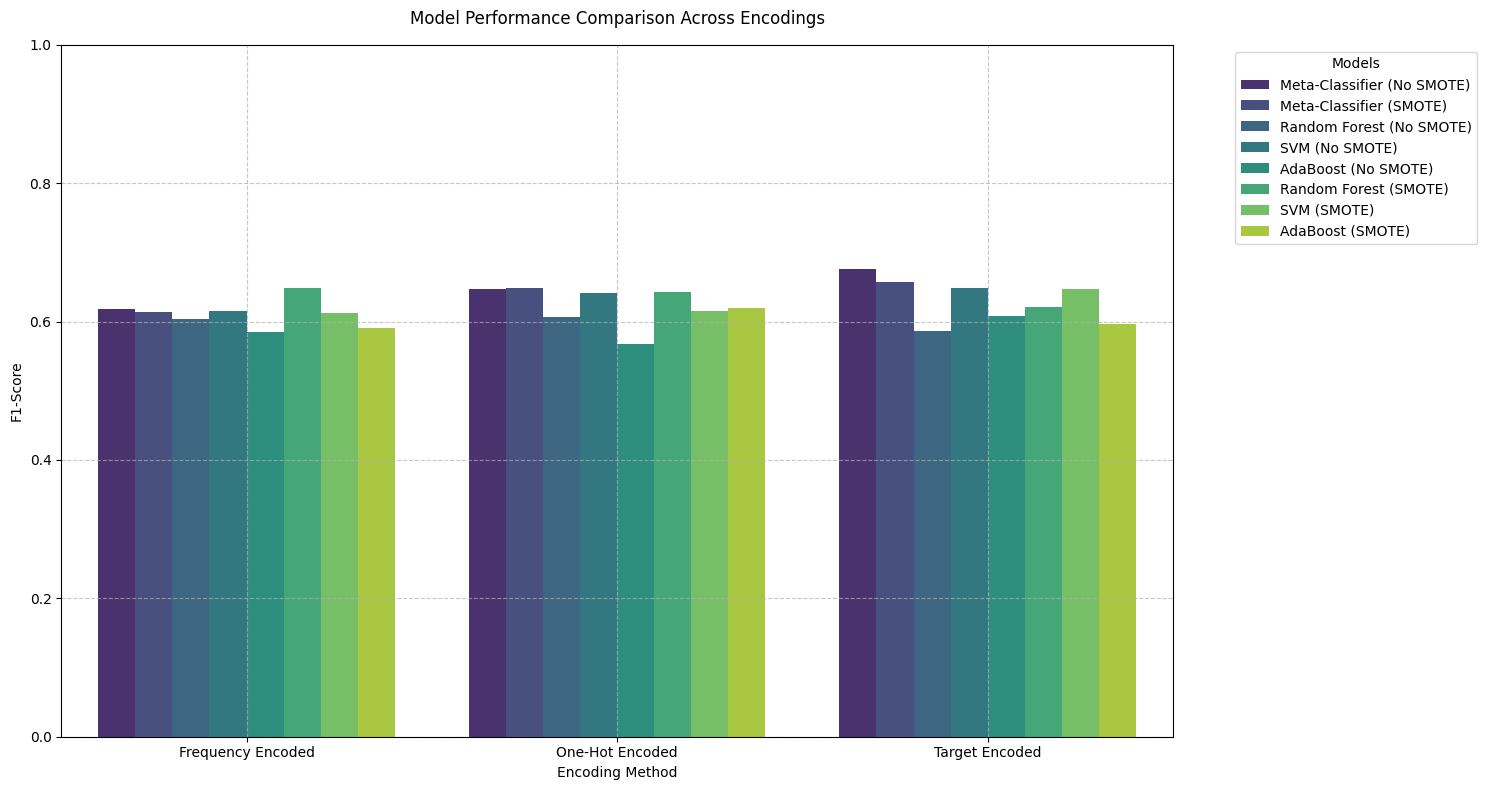

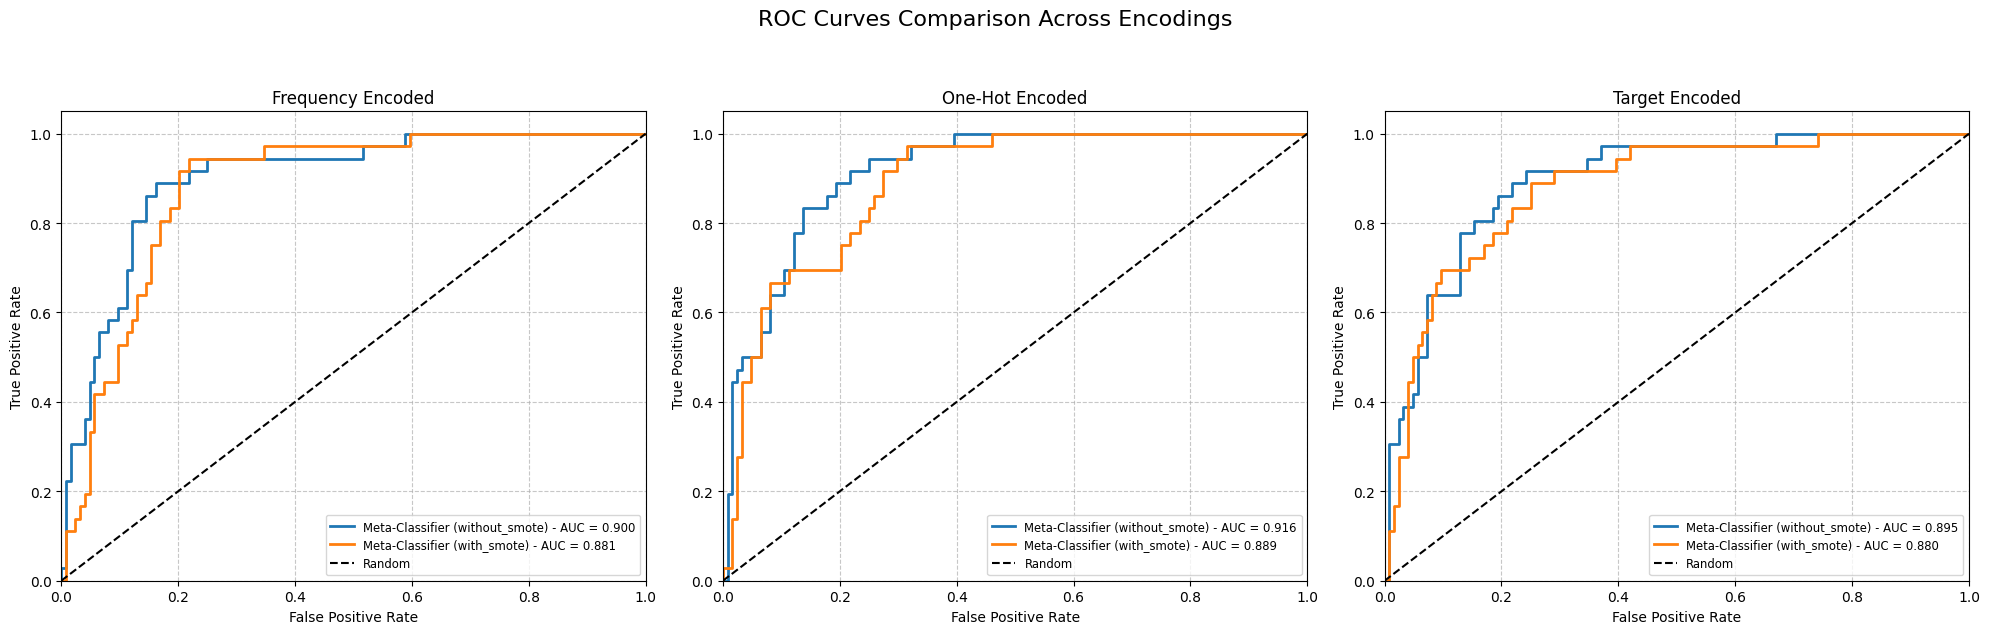

In [64]:
def train_and_evaluate(dataset, encoding_name, use_smote=False):
    X = dataset.drop(columns=['Class/ASD'])
    y = dataset['Class/ASD']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    meta_train, meta_test, cv_scores, top_features = generate_hybrid_meta_features(
        base_models, X_train, X_test, y_train, n_top_features=5, use_smote=use_smote
    )
    
    # Scale meta-features
    scaler = StandardScaler()
    meta_train_scaled = scaler.fit_transform(meta_train)
    meta_test_scaled = scaler.transform(meta_test)
    
    if use_smote:
        smote = SMOTE(random_state=42)
        meta_train_scaled, y_train = smote.fit_resample(meta_train_scaled, y_train)
    
    meta_learner.fit(meta_train_scaled, y_train)
    y_pred = meta_learner.predict(meta_test_scaled)
    meta_f1 = f1_score(y_test, y_pred)
    y_pred_proba = meta_learner.predict_proba(meta_test_scaled)[:, 1]
    
    print(f"\nResults for {encoding_name} {'with' if use_smote else 'without'} SMOTE:")
    print("\nTop Important Features Used:", top_features)
    print("\nBase Models CV Scores:")
    for name, score in cv_scores.items():
        print(f"{name}: {score:.3f}")
    print(f"\nMeta-Classifier F1 Score: {meta_f1:.3f}")
    
    return meta_f1, cv_scores, top_features, y_pred_proba, meta_test_scaled, y_test

# Load and evaluate for each encoding
datasets = {
    'Frequency Encoded': pd.read_csv('Data/Processed Data/frequency_encoded_data.csv'),
    'One-Hot Encoded': pd.read_csv('Data/Processed Data/one_hot_encoded_data.csv'),
    'Target Encoded': pd.read_csv('Data/Processed Data/target_encoded_data.csv')
}

results = {}
for encoding_name, dataset in datasets.items():
    results[encoding_name] = {
        'without_smote': train_and_evaluate(dataset, encoding_name, False),
        'with_smote': train_and_evaluate(dataset, encoding_name, True)
    }

# Generate plots
plot_f1_scores(results)
plot_all_roc_curves(results)